In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # data visializing
import seaborn as sns # data visualization
from scipy.stats import skew
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression,Ridge, RidgeCV, LassoCV, Lasso
from sklearn.metrics import mean_squared_error
from sklearn.cluster import DBSCAN
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

ModuleNotFoundError: No module named 'xgboost'

## 1.Exploratory data analyst

#### a) First look at columns and missing data

Time to look on the dataset and do some analyse before jumping to the modeling. We have 9 features and one variable to predict. First two features describe location of the neigberhood: longitude and latitude. Other describe sum of rooms, bedrooms, population and households and finaly we have median of house and median of income. The last is variable which we are going to predict. 

In [3]:
train = pd.read_csv('housing.csv')
train.head()

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY

In [4]:
# Dataset contain 20640 rows and 10 features 
train.shape

(20640, 10)

In [5]:
train.describe()
#there are only missing values in 'total_bedrooms' column

longitude      latitude  housing_median_age   total_rooms  \
count  20640.000000  20640.000000        20640.000000  20640.000000   
mean    -119.569704     35.631861           28.639486   2635.763081   
std        2.003532      2.135952           12.585558   2181.615252   
min     -124.350000     32.540000            1.000000      2.000000   
25%     -121.800000     33.930000           18.000000   1447.750000   
50%     -118.490000     34.260000           29.000000   2127.000000   
75%     -118.010000     37.710000           37.000000   3148.000000   
max     -114.310000     41.950000           52.000000  39320.000000   

       total_bedrooms    population    households  median_income  \
count    20433.000000  20640.000000  20640.000000   20640.000000   
mean       537.870553   1425.476744    499.539680       3.870671   
std        421.385070   1132.462122    382.329753       1.899822   
min          1.000000      3.000000      1.000000       0.499900   
25%        296.000000    787.000000    280.000000       2.563400   
50%        435.000000   1166.000000    409.000000       3.534800   
75%        647.000000   1725.000000    605.000000       4.743250   
max       6445.000000  35682.000000   6082.000000      15.000100   

       median_house_value  
count        20640.000000  
mean        206855.816909  
std         115395.615874  
min          14999.000000  
25%         119600.000000  
50%         179700.000000  
75%         264725.000000  
max         500001.000000

In [6]:
print("Checking missing values in dataset")
print(train.isnull().any())
print ("Missing values {0:3d} in 'total_bedrooms'".format(sum(train.total_bedrooms.isnull())))
print ("Percentage of missing rows {0:2.3f}".format(100*sum(train.total_bedrooms.isnull())/train.shape[0]))

Checking missing values in dataset
longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms         True
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
dtype: bool
Missing values 207 in 'total_bedrooms'
Percentage of missing rows 1.003


In [7]:
train.dtypes

longitude             float64
latitude              float64
housing_median_age    float64
total_rooms           float64
total_bedrooms        float64
population            float64
households            float64
median_income         float64
median_house_value    float64
ocean_proximity        object
dtype: object

In [8]:
train.ocean_proximity.value_counts()

<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: ocean_proximity, dtype: int64

First expresions: 
-we have one categorical variable which show distance to ocean with 5 unique values but only 4 are significant for us
-only one column has missing values, there are only 200~ 1%, one of  ideaas is to impute data with mean or average of whole column or just remove rows. I will probably remove it because percentage is not big and its not going to influence model.

In [9]:
train.dropna(axis=0, how='any', inplace=True)

### b) Look at single features

   #### -house_median_value
   Lets start with 'median_house_value', Min looks like promotion price 14.999, sound almost imposible to be true. Second peak around 500000 doesn't look good too. Unfortunetly we can't ask anyone who was collecting data about reason. But I think we can assume that 500001 is a maximum value probably also describing values greater than this. It's bringing the problem that miss labeled data can't create precisse model. I am going to remove it and generalize model on range to 500000. 

Text(0.5,1,'Histogram of house median value')

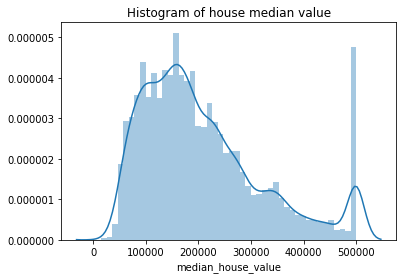

In [10]:
sns.distplot(train.median_house_value).set_title('Histogram of house median value')

In [11]:
print("The most often appearing values")
train.median_house_value.value_counts().sort_values(ascending=False).head(3)

The most often appearing values


500001.0    958
137500.0    119
162500.0    116
Name: median_house_value, dtype: int64

In [12]:
train= train.loc[(train.median_house_value<500001)]

In [13]:
print("Skewness of 'median_house value' {0:2f}".format(skew(train['median_house_value'])))
print("Skewness of 'median_house value' after using log {0:2f}".format(skew(np.log(train['median_house_value']))))

Skewness of 'median_house value' 0.810086
Skewness of 'median_house value' after using log -0.294440


Text(0.5,1,'Histogram of house log median value')

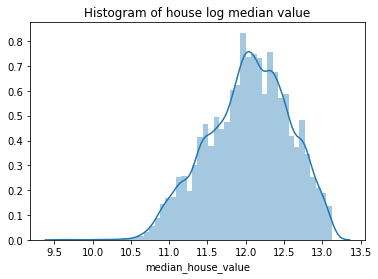

In [14]:
sns.distplot(np.log(train.median_house_value)).set_title('Histogram of house log median value')

In [15]:
print(skew(train['median_house_value']))
print(skew(np.log(train['median_house_value'])))

0.8100859862017087
-0.2944402457432595


#### -median_income
Time for other features. Median income distribution is little right skeewed and has 3 outliers 15.001. Probably its the same situation like with house_mean_value, someone was saving maximum values with 0001 after decimal. 

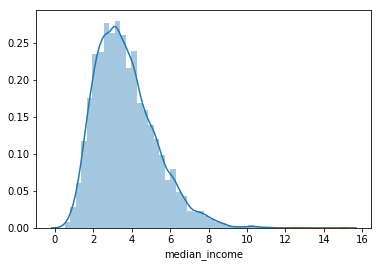

In [16]:
sns.distplot(train.median_income)

In [17]:
train.loc[(train.median_income>14)]

longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
1566     -121.96     37.74                 2.0        200.0            20.0   
18501    -121.59     37.19                52.0        220.0            32.0   
18504    -121.96     37.13                26.0         50.0             5.0   

       population  households  median_income  median_house_value  \
1566         25.0         9.0        15.0001            350000.0   
18501        55.0        26.0        15.0001            131300.0   
18504        17.0         4.0        15.0001            400000.0   

      ocean_proximity  
1566        <1H OCEAN  
18501       <1H OCEAN  
18504       <1H OCEAN

In [18]:
print(skew(train['median_income']))
print(skew(np.log(train['median_income'])))

0.9106616818538884
-0.3711654569125261


#### - housing_median_age
Next situation where distribution has some threshold and never crosing it. 

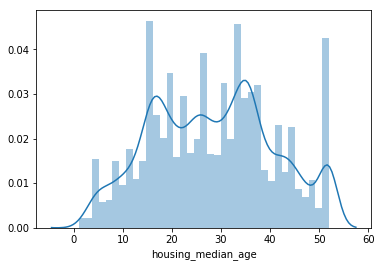

In [19]:
sns.distplot(train.housing_median_age )

In [20]:
print("Cardinality or house median age ")
train.housing_median_age.value_counts().sort_values(ascending=False).head(5)

Cardinality or house median age 


52.0    1096
36.0     816
35.0     783
16.0     747
17.0     680
Name: housing_median_age, dtype: int64

In [21]:
#train.housing_median_age=np.log(train.housing_median_age)

In [22]:
#train.housing_median_age=np.exp(train.housing_median_age)

In [23]:
#remove every observation which is 52 old and value bigger than 5000000
train_new= train.loc[((train.housing_median_age<52) & (train.median_house_value<500000 ))]

### -ocean_proximity
The only categorical variable available show some insight. I can see some corelation and for example most of 'INLAND' places are quite cheap with small box so show have high concentration of observations. Fifty percentego of INLAND observation are in range between Q1=77500 and Q3=147900. But also 294 observations are above Q3+ 1.5*IQR and 108 above Q3+ 3*IQR  where IQR = Q3-Q1. What show quite big group of outliers. 

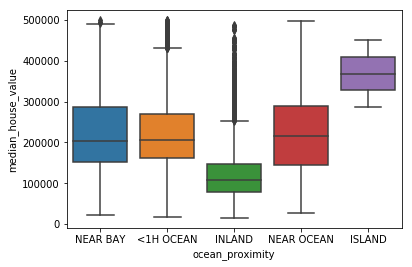

In [24]:
sns.boxplot(x='ocean_proximity', y='median_house_value',data=train_new)

In [25]:
train.ocean_proximity.value_counts()

<1H OCEAN     8505
INLAND        6469
NEAR OCEAN    2419
NEAR BAY      2077
ISLAND           5
Name: ocean_proximity, dtype: int64

In [26]:
print(" IQR = Q3-Q1=147900-77500=70400")
print("Amount of values above Q3 +1.5*IQR: {0:2.0f}".format(train_new['median_house_value'].loc[(train_new.ocean_proximity=='INLAND') & (train_new.median_house_value>253000)].count()))
print("Amount of values above Q3 +3*IQR: {0:2.0f}".format(train_new['median_house_value'].loc[(train_new.ocean_proximity=='INLAND') & (train_new.median_house_value>336027)].count()))


 IQR = Q3-Q1=147900-77500=70400
Amount of values above Q3 +1.5*IQR: 294
Amount of values above Q3 +3*IQR: 108


In [27]:
print("Basic statistics and quartile of median_house value for INLAND")
train_new['median_house_value'].loc[(train_new.ocean_proximity=='INLAND') ].describe()

Basic statistics and quartile of median_house value for INLAND


count      6289.000000
mean     123076.211957
std       65277.040805
min       14999.000000
25%       77500.000000
50%      108300.000000
75%      148000.000000
max      486800.000000
Name: median_house_value, dtype: float64

## 2. Feature enginering

Dataset contain features about total of rooms, bedrooms, housholds, population. We can easily transform for more usefull by counting average room per house, bedroom per house, people per house. 

In [28]:
# By having total numbers we can count average room per houshold, bed per houshold, people per houshold
train_new['room_avg_h']= train_new['total_rooms'] / train_new['households'] 
train_new['bed_avg_h'] = train_new['total_bedrooms'] / train_new['households'] 
train_new['pep_avg_h'] = train_new['population'] / train_new['households'] 


In [29]:
train_new.isnull().any()

longitude             False
latitude              False
housing_median_age    False
total_rooms           False
total_bedrooms        False
population            False
households            False
median_income         False
median_house_value    False
ocean_proximity       False
room_avg_h            False
bed_avg_h             False
pep_avg_h             False
dtype: bool

Text(0.5,1,'Histogram of average people per household')

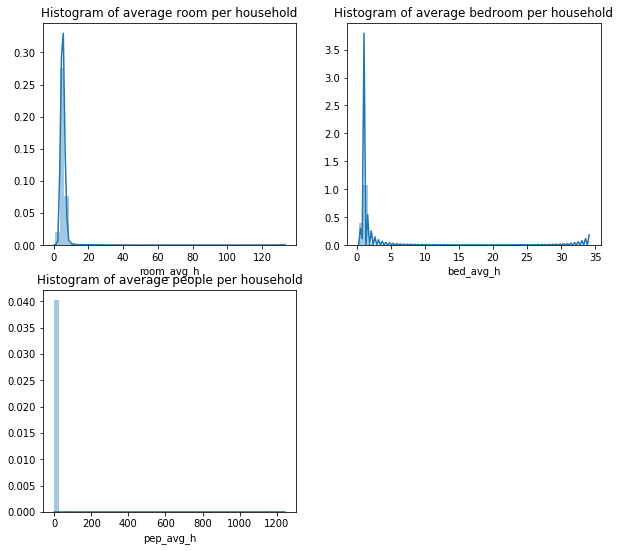

In [30]:
fig = plt.figure(figsize=(10, 9)) 
plt.subplot(2, 2, 1)
sns.distplot(train_new['room_avg_h']).set_title('Histogram of average room per household')
plt.subplot(2, 2, 2)
sns.distplot(train_new['bed_avg_h']).set_title('Histogram of average bedroom per household')
plt.subplot(2, 2, 3)
sns.distplot(train_new['pep_avg_h']).set_title('Histogram of average people per household')

There are some dirty outliers, more than average 500 people per house or 100 rooms doesn't loooks right for whole neighbourhod. I will remove it because some alghoritms are highly influented by outliers. 

In [31]:
print("List of observations with average room per house greater than 100")
train_new.loc[(train_new['room_avg_h']>100),'room_avg_h'].round().value_counts()

List of observations with average room per house greater than 100


133.0    1
Name: room_avg_h, dtype: int64

In [32]:
print("List of observations with average bedroom per house greater than 20")
train_new.loc[(train_new['bed_avg_h']>20),'bed_avg_h'].round().value_counts()

List of observations with average bedroom per house greater than 20


34.0    1
Name: bed_avg_h, dtype: int64

In [33]:
print("List of observations with average people per house greater than 100")
train_new.loc[(train_new['pep_avg_h']>100),'pep_avg_h'].round().value_counts()

List of observations with average people per house greater than 100


1243.0    1
502.0     1
600.0     1
Name: pep_avg_h, dtype: int64

In [34]:
#removing outliers from dataset
train_new= train_new.loc[((train_new.room_avg_h<100) & (train_new.bed_avg_h<20) &(train_new.pep_avg_h<30))]

Text(0.5,1,'Histogram of average people per household')

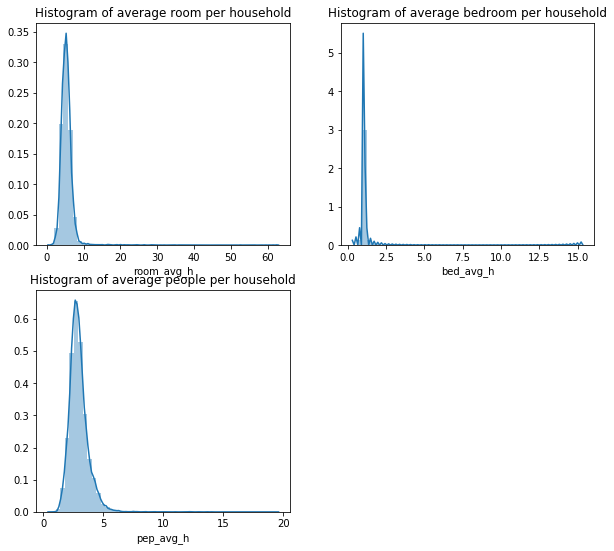

In [35]:
#ploting data without outliers
fig = plt.figure(figsize=(10, 9)) 
plt.subplot(2, 2, 1)
sns.distplot(train_new['room_avg_h']).set_title('Histogram of average room per household')
plt.subplot(2, 2, 2)
sns.distplot(train_new['bed_avg_h']).set_title('Histogram of average bedroom per household')
plt.subplot(2, 2, 3)
sns.distplot(train_new['pep_avg_h']).set_title('Histogram of average people per household')

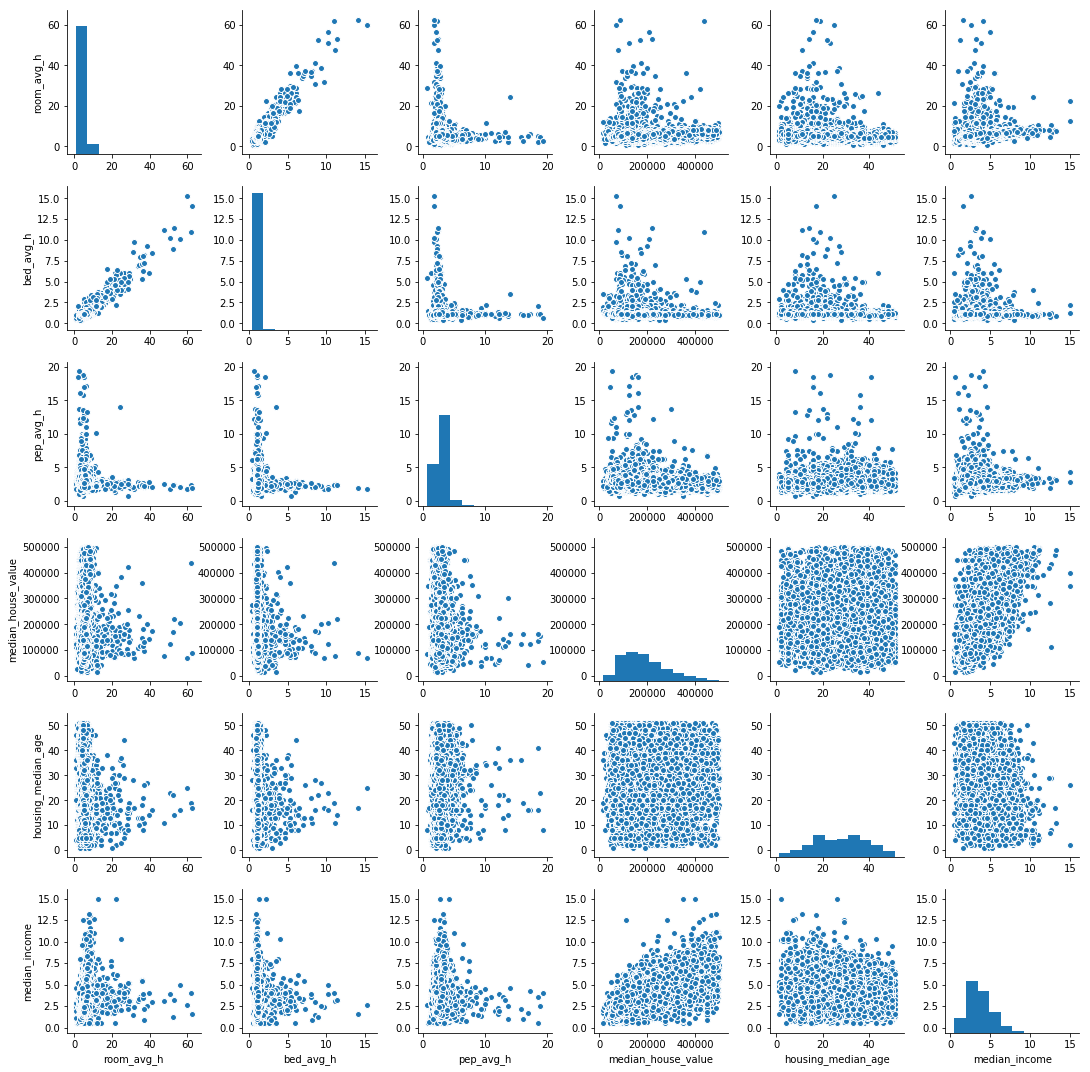

In [36]:
sns.pairplot(train_new[['room_avg_h','bed_avg_h','pep_avg_h', 'median_house_value','housing_median_age','median_income']])

In [37]:
col=['housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income','median_house_value' ]

In [38]:
col_new=['housing_median_age', 'total_rooms', 'room_avg_h', 'median_income','median_house_value' ]

### Heatmap
Time to look on heatmap of correletion of diferent features. Four input features show extreamly high collinearity (total_rooms, total_bedrooms, population, households) I don't need all and going to leave only households. Other pair is longtitude and latitude but this doesn't affect us much. What is the most interesting how features are corelated with median_house_value, its strong positive corelation with median_income, modorate  negative with ocean_proximity(INLAND) and weak positive with places '1<H OcEAN'. 

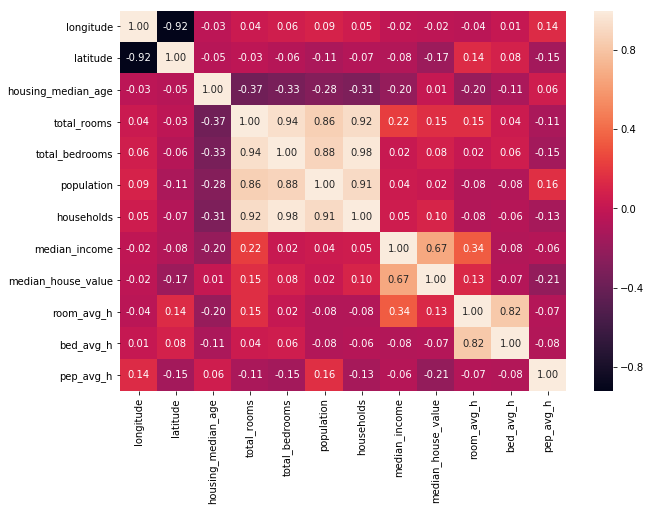

In [39]:
plt.figure(figsize=(10, 7)) 
sns.heatmap(train_new.corr(),annot=True, fmt=".2f")

### Localization - longitude and latitude.
    By using both we can visualize generall shape of area, its looks like California so its good. Size of the marker show amount of households in neighbourghod and color median value. It easy to notice big cities on the coast where pricies are higher. I am going to use clastering to get more data.

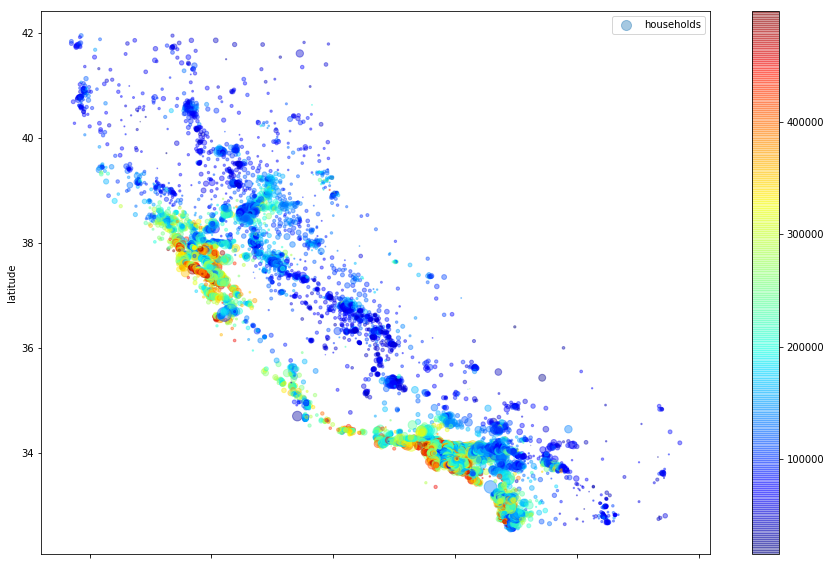

In [40]:
train_new.plot(kind = "scatter", x= "longitude", y = "latitude", alpha = 0.4, s = train_new["households"]/30, 
             label = "households", figsize=(15,10), c=train_new['median_house_value'],cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

To find clusters im using DBSCAN - Density-Based Spatial Clustering of Applications with Noise, alogorithm is implemented in Sklearn library. I will create clusters of people what can bring some extra information to algorithm.

In [41]:
clust= DBSCAN(eps=0.2).fit(train_new[['longitude', 'latitude']])

In [42]:
np.unique(clust.labels_)

array([-1,  0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15,
       16, 17, 18], dtype=int64)

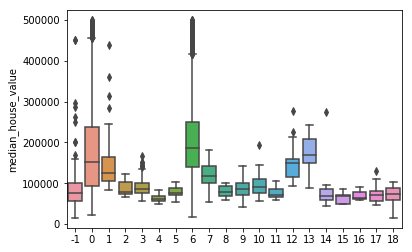

In [43]:
sns.boxplot(y=train_new['median_house_value'], x=clust.labels_)

In [44]:
train_new['cluster'] =clust.labels_
train_new['cluster']=train_new['cluster'].astype('category')
#train_new=pd.get_dummies(train_new, drop_first=True)

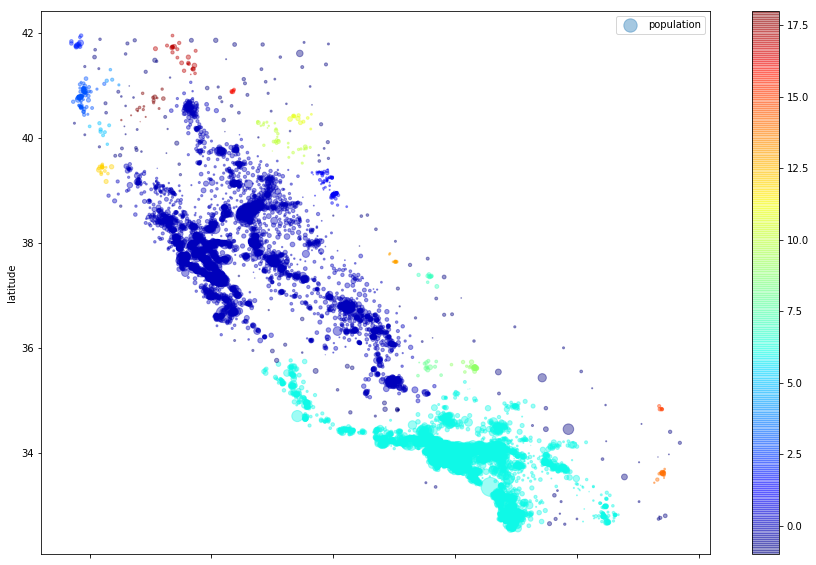

In [45]:
train_new.plot(kind = "scatter", x= "longitude", y = "latitude", alpha = 0.4, s = train_new["population"]/100, 
             label = "population", figsize=(15,10), c=train_new["cluster"],cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

Clustering created one column with 20 different numerical variables (-1...18)  but it doesn't mean that 1 is close to 2 in any way. So we need to creat dummy variables. Whats mean create sparse matrix with 19 binary columns. Observation has value 1 in one column corespond to the cluster which belong and 0 in others. 

In [46]:
train_new=pd.get_dummies(train_new, drop_first=True)

In [47]:
train_new.drop(['total_rooms','total_bedrooms','population'],axis=1, inplace=True)

In [48]:
train_new.head()

longitude  latitude  housing_median_age  households  median_income  \
0     -122.23     37.88                41.0       126.0         8.3252   
1     -122.22     37.86                21.0      1138.0         8.3014   
8     -122.26     37.84                42.0       595.0         2.0804   
15    -122.26     37.85                50.0       264.0         2.1250   
18    -122.26     37.84                50.0       419.0         1.9911   

    median_house_value  room_avg_h  bed_avg_h  pep_avg_h  \
0             452600.0    6.984127   1.023810   2.555556   
1             358500.0    6.238137   0.971880   2.109842   
8             226700.0    4.294118   1.117647   2.026891   
15            140000.0    4.242424   1.071970   2.640152   
18            158700.0    5.343675   1.085919   2.362768   

    ocean_proximity_INLAND     ...      cluster_9  cluster_10  cluster_11  \
0                        0     ...              0           0           0   
1                        0     ...              0           0           0   
8                        0     ...              0           0           0   
15                       0     ...              0           0           0   
18                       0     ...              0           0           0   

    cluster_12  cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  \
0            0           0           0           0           0           0   
1            0           0           0           0           0           0   
8            0           0           0           0           0           0   
15           0           0           0           0           0           0   
18           0           0           0           0           0           0   

    cluster_18  
0            0  
1            0  
8            0  
15           0  
18           0  

[5 rows x 32 columns]

In [ ]:
#one cell transition
train = pd.read_csv('housing.csv')
train.dropna(axis=0, how='any', inplace=True)
#remove every observation which is 52 old and value bigger than 5000000
train_new= train.loc[((train.housing_median_age<52) & (train.median_house_value<500000 ))]
#train_new=train
# By having total numbers we can count average room per houshold, bed per houshold, people per houshold
train_new['room_avg_h']= train_new['total_rooms'] / train_new['households'] 
train_new['bed_avg_h'] = train_new['total_bedrooms'] / train_new['households'] 
train_new['pep_avg_h'] = train_new['population'] / train_new['households']
train_new= train_new.loc[((train_new.room_avg_h<100) & (train_new.bed_avg_h<20) &(train_new.pep_avg_h<30)&(train_new.median_income<15))]
train_new['longitude'] = -train_new['longitude']
train_new=pd.get_dummies(train_new)

In [49]:
train_new.longitude=-train_new.longitude

In [50]:
train_new.head()

longitude  latitude  housing_median_age  households  median_income  \
0      122.23     37.88                41.0       126.0         8.3252   
1      122.22     37.86                21.0      1138.0         8.3014   
8      122.26     37.84                42.0       595.0         2.0804   
15     122.26     37.85                50.0       264.0         2.1250   
18     122.26     37.84                50.0       419.0         1.9911   

    median_house_value  room_avg_h  bed_avg_h  pep_avg_h  \
0             452600.0    6.984127   1.023810   2.555556   
1             358500.0    6.238137   0.971880   2.109842   
8             226700.0    4.294118   1.117647   2.026891   
15            140000.0    4.242424   1.071970   2.640152   
18            158700.0    5.343675   1.085919   2.362768   

    ocean_proximity_INLAND     ...      cluster_9  cluster_10  cluster_11  \
0                        0     ...              0           0           0   
1                        0     ...              0           0           0   
8                        0     ...              0           0           0   
15                       0     ...              0           0           0   
18                       0     ...              0           0           0   

    cluster_12  cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  \
0            0           0           0           0           0           0   
1            0           0           0           0           0           0   
8            0           0           0           0           0           0   
15           0           0           0           0           0           0   
18           0           0           0           0           0           0   

    cluster_18  
0            0  
1            0  
8            0  
15           0  
18           0  

[5 rows x 32 columns]

In [51]:
train_new.iloc[:,0:9]=train_new.iloc[:,0:9].apply(np.log1p)


In [52]:
train_new.head()

longitude  latitude  housing_median_age  households  median_income  \
0    4.814053  3.660480            3.737670    4.844187       2.232720   
1    4.813971  3.659965            3.091042    7.037906       2.230165   
8    4.814296  3.659451            3.761200    6.390241       1.125059   
15   4.814296  3.659708            3.931826    5.579730       1.139434   
18   4.814296  3.659451            3.931826    6.040255       1.095641   

    median_house_value  room_avg_h  bed_avg_h  pep_avg_h  \
0            13.022766    2.077455   0.704982   1.268511   
1            12.789687    1.979364   0.678988   1.134572   
8            12.331387    1.666596   0.750306   1.107536   
15           11.849405    1.656784   0.728500   1.292025   
18           11.974777    1.847458   0.735209   1.212765   

    ocean_proximity_INLAND     ...      cluster_9  cluster_10  cluster_11  \
0                        0     ...              0           0           0   
1                        0     ...              0           0           0   
8                        0     ...              0           0           0   
15                       0     ...              0           0           0   
18                       0     ...              0           0           0   

    cluster_12  cluster_13  cluster_14  cluster_15  cluster_16  cluster_17  \
0            0           0           0           0           0           0   
1            0           0           0           0           0           0   
8            0           0           0           0           0           0   
15           0           0           0           0           0           0   
18           0           0           0           0           0           0   

    cluster_18  
0            0  
1            0  
8            0  
15           0  
18           0  

[5 rows x 32 columns]

## 2. Training
I want to start with simple model like just Lasso and then move to more complex ensamble method like random forest. General I will use root mean square logistic error as loss function.
First step is to split data 80/20 as training and test dataset and after scale every column to mean=0 and std=1.

In [54]:
X_train, X_test, y_train, y_test = train_test_split(train_new.drop(['median_house_value' ], axis=1), train_new['median_house_value'], test_size=0.20, random_state=42)

In [55]:
#y_test = np.log1p(y_test)
#y_train = np.log1p(y_train)
X_train_s = preprocessing.scale(X_train)
X_test_s = preprocessing.scale(X_test)

### a) Lasso model
Linear Model trained with L1 prior as regularizer. Alpha is the only hyper parameter to tune. Additionaly I'm using GridSearchCv from sklearn which take as arguments model, parameters and other atributes like how many cross fold validation.
GridSearchCv is checking all possible combination so if we want to check parameter alpha (7 different values) and beta (5 different) with cross validation 5 he is going to fit 175 models 7*5*5. 

In [117]:
parameters = [{'alpha':[0.00001,0.0001,0.002, 0.004, 0.05, 0.1]}]
LA_model = Lasso()
clf=GridSearchCV(LA_model, parameters, verbose=3, cv=5)
clf.fit(X_train_s,y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.7219688247626119, total=   0.1s
[CV] alpha=1e-05 .....................................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s


[CV] ............ alpha=1e-05, score=0.7026558784505957, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.7027602068686918, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.6902106411370906, total=   0.0s
[CV] alpha=1e-05 .....................................................
[CV] ............ alpha=1e-05, score=0.7084124112232537, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ............ alpha=0.0001, score=0.722047423549737, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........... alpha=0.0001, score=0.7025635688025598, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] ........... alpha=0.0001, score=0.7027828575437708, total=   0.0s
[CV] alpha=0.0001 ....................................................
[CV] .

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    1.7s finished


GridSearchCV(cv=5, error_score='raise',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid=[{'alpha': [1e-05, 0.0001, 0.002, 0.004, 0.05, 0.1]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

Argument best_estimator return a set of parameters of best model.

In [118]:
clf.best_estimator_

Lasso(alpha=0.0001, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [ ]:
Mean square error of predictade 

In [119]:
y_pred_LA=clf.best_estimator_.predict(X_test_s)
MSE_LA=mean_squared_error(np.expm1(y_test), np.expm1(y_pred_LA))**(1/2)
MSE_LA

57654.139586892437

In [120]:
clf.cv_results_['mean_test_score']

array([ 0.70520239,  0.70522191,  0.70354414,  0.69882273,  0.63207908,
        0.56436225])

In [122]:
alphas=[0.00001,0.0001,0.002, 0.004, 0.05, 0.1]

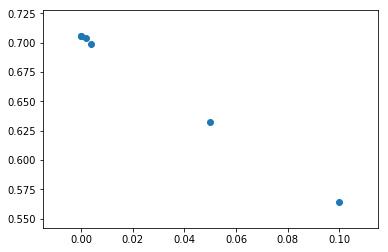

In [123]:
plt.scatter(alphas, clf.cv_results_['mean_test_score'] )

## b) Random forest
Algorythm is creating a forest of decision trees. Its an ennsemble method which use many trees from forest to avoid  common problem of overfiting to data. Its generalizng well and have few parameters to tune. For exampel: 'n_estimators' - noumber trees in model, 'max_depth' how deep is going to be tree, 'min_samples_split'- minimum number of observations to split and several more parameters.

In [ ]:
parameters = [{'n_estimators':[100,200,500]}]

In [153]:
# parameters and ranges to plot
param_grid = {"n_estimators": [100],
              "max_depth": np.arange(21, 36, 3),
              'min_samples_split': [5,10,20],
             }

In [154]:
RF_model = RandomForestRegressor(random_state=44)

In [155]:
clf=GridSearchCV(RF_model, param_grid, verbose=3, cv=5)

In [156]:
clf.fit(X_train_s,y_train)

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.8192310783592411, total=   5.5s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    5.6s remaining:    0.0s


[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.81727526699737, total=   5.4s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   11.3s remaining:    0.0s


[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.8179926044475954, total=   5.4s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.8190146595124619, total=   5.4s
[CV] max_depth=21, min_samples_split=5, n_estimators=100 .............
[CV]  max_depth=21, min_samples_split=5, n_estimators=100, score=0.8198473288662419, total=   5.4s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split=10, n_estimators=100, score=0.8186146230267544, total=   5.0s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split=10, n_estimators=100, score=0.8150710734141731, total=   5.0s
[CV] max_depth=21, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=21, min_samples_split=10, n_estimators=100, score=0.8163318118875387, total=   5.0s
[CV] max_depth=21, min_samples_split=10, n_estim

[CV]  max_depth=30, min_samples_split=10, n_estimators=100, score=0.8153943323111207, total=   5.0s
[CV] max_depth=30, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=30, min_samples_split=10, n_estimators=100, score=0.8159748368242297, total=   5.0s
[CV] max_depth=30, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=30, min_samples_split=10, n_estimators=100, score=0.8186863176962108, total=   5.0s
[CV] max_depth=30, min_samples_split=10, n_estimators=100 ............
[CV]  max_depth=30, min_samples_split=10, n_estimators=100, score=0.817927726128695, total=   5.0s
[CV] max_depth=30, min_samples_split=20, n_estimators=100 ............
[CV]  max_depth=30, min_samples_split=20, n_estimators=100, score=0.8145411393497376, total=   4.5s
[CV] max_depth=30, min_samples_split=20, n_estimators=100 ............
[CV]  max_depth=30, min_samples_split=20, n_estimators=100, score=0.8116298193897968, total=   4.5s
[CV] max_depth=30, min_samples_split=20, n_est

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:  6.5min finished


GridSearchCV(cv=5, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=44, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_estimators': [100], 'max_depth': array([21, 24, 27, 30, 33]), 'min_samples_split': [5, 10, 20]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=3)

In [150]:
clf.cv_results_['mean_test_score']

array([ 0.80966774,  0.81710499,  0.81852392,  0.8190153 ,  0.81920116,
        0.81926479,  0.81890348,  0.81911209])

In [159]:
clf.cv_results_

{'mean_fit_time': array([ 5.47697453,  5.06126852,  4.63135519,  5.48422441,  5.00596056,
         4.58903761,  5.46425133,  5.0266798 ,  4.60495558,  5.46012688,
         5.033531  ,  4.59175239,  5.45669055,  5.03289132,  4.61178789]),
 'mean_score_time': array([ 0.0486011 ,  0.03980021,  0.03720055,  0.049681  ,  0.04336019,
         0.03300018,  0.04744067,  0.03536072,  0.0436801 ,  0.04696035,
         0.03144069,  0.03388042,  0.04888043,  0.03492012,  0.03180003]),
 'mean_test_score': array([ 0.81867208,  0.81728649,  0.81289276,  0.81887714,  0.81724149,
         0.81279891,  0.81883154,  0.81733902,  0.81281324,  0.81881553,
         0.81729084,  0.81287893,  0.81885605,  0.81731034,  0.81283389]),
 'mean_train_score': array([ 0.96464154,  0.9463432 ,  0.91728752,  0.96543283,  0.94691125,
         0.91754665,  0.96558301,  0.94700963,  0.91759212,  0.9656112 ,
         0.94704613,  0.91760361,  0.96560095,  0.9470459 ,  0.91760536]),
 'param_max_depth': masked_array(data = [

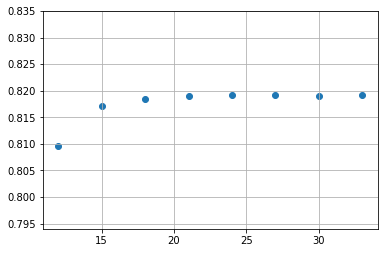

In [152]:
max_depth= np.arange(12, 36, 3)
plt.scatter(max_depth, clf.cv_results_['mean_test_score'] )
plt.grid()

In [157]:
y_pred_RF=clf.best_estimator_.predict(X_test_s)

In [ ]:
clf.best_estimator_

In [160]:
mean_squared_error(np.expm1(y_test), np.expm1(y_pred_RF))**(1/2)

47314.709452002127

In [161]:
error = ((np.expm1(y_test) -np.expm1(y_pred_RF))**2)**(1/2)

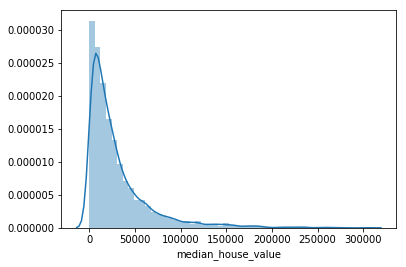

In [162]:
sns.distplot(error)

In [ ]:
X_test.latitude =np.expm1(X_test.latitude)
X_test.longitude =np.expm1(X_test.longitude)
X_test.error = error
#X_test.longitude =np.expm1(X_test.longitude)

In [ ]:

X_test.plot(kind = "scatter", x= "longitude", y = "latitude", alpha = 0.4, s = 2*X_test['households'], 
             label = "population", figsize=(15,10), c=error ,cmap = plt.get_cmap("jet"), colorbar = True)
plt.legend()

## c) 